In [ ]:
import pandas as pd

data = pd.read_excel("gpt-4.xlsx")

print(data.head())


                                                data  \
0  This 60-year-old male was hospitalized due to ...   
1  A 39-year-old man was hospitalized due to an i...   
2  One week after a positive COVID-19 result this...   
3  This 69-year-old male was admitted to the ICU ...   
4  This 57-year-old male was admitted to the ICU ...   

                                        conversation  
0  Doctor: Good morning, how are you feeling toda...  
1  Doctor: Hello, how are you feeling today?\nPat...  
2  Doctor: Hello, how are you feeling today?\nPat...  
3  Doctor: Hello, how are you feeling today?\nPat...  
4  Doctor: Good morning, how are you feeling toda...  


In [ ]:
print(data.isnull().sum())

data            0
conversation    0
dtype: int64


In [ ]:
data.dtypes

,0
data,object
conversation,object


In [ ]:
import re
# Extract age
def extract_age(text):
    match = re.search(r'(\d+)-year-old', str(text))
    return int(match.group(1)) if match else None

data['age'] = data['data'].apply(extract_age)

# Handle missing ages
data['age'] = data['age'].fillna(data['age'].median())


In [ ]:
data['conversation'] = data['conversation'].fillna('')


In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply the function to the conversation column
data['cleaned_conversation'] = data['conversation'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(data['age'].describe())


count    3377.000000
mean       46.669233
std        19.866420
min         1.000000
25%        33.000000
50%        48.000000
75%        61.000000
max        96.000000
Name: age, dtype: float64


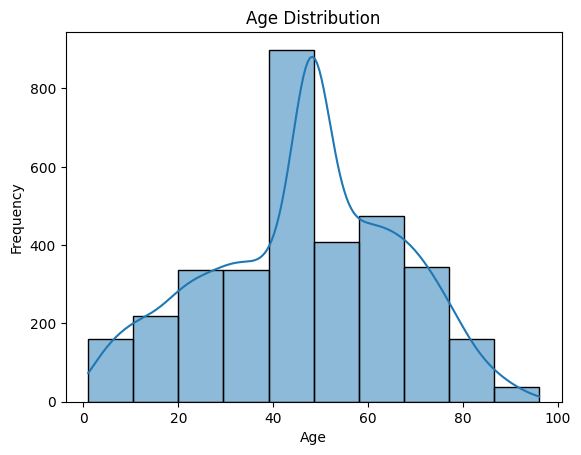

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['age'], kde=True, bins=10)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [ ]:
data['word_count'] = data['cleaned_conversation'].apply(lambda x: len(x.split()))


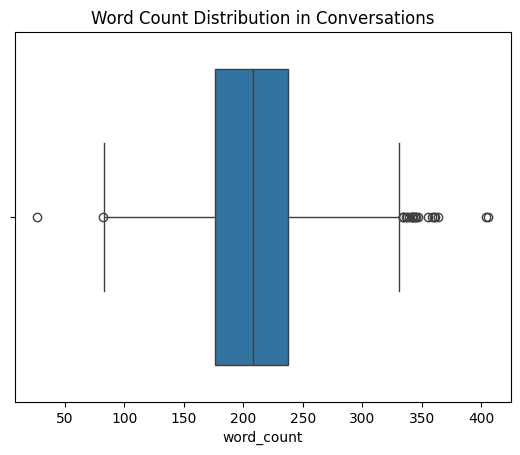

In [ ]:
sns.boxplot(x=data['word_count'])
plt.title('Word Count Distribution in Conversations')
plt.show()


In [ ]:
from collections import Counter

all_words = ' '.join(data['cleaned_conversation']).split()
common_words = Counter(all_words).most_common(10)
print(common_words)


[('doctor', 38447), ('patient', 33005), ('yes', 9484), ('okay', 9159), ('see', 8005), ('well', 5304), ('thats', 5247), ('also', 4972), ('need', 4859), ('feeling', 4585)]


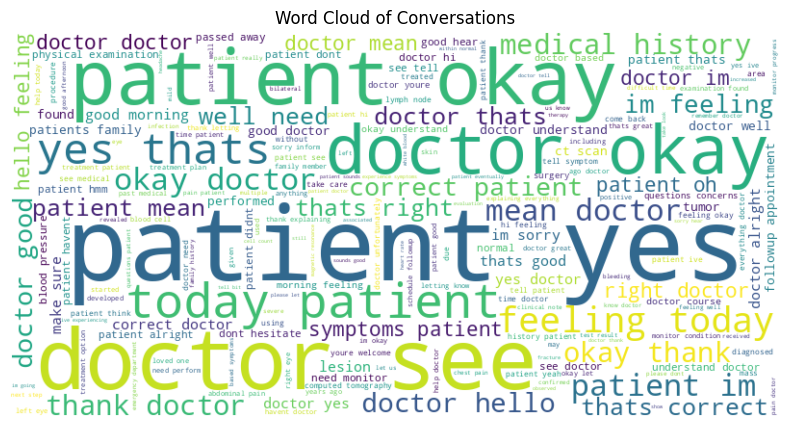

In [ ]:
from wordcloud import WordCloud

text = ' '.join(data['cleaned_conversation'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Conversations')
plt.show()


In [ ]:
from textblob import TextBlob

data['sentiment'] = data['cleaned_conversation'].apply(lambda x: TextBlob(x).sentiment.polarity)


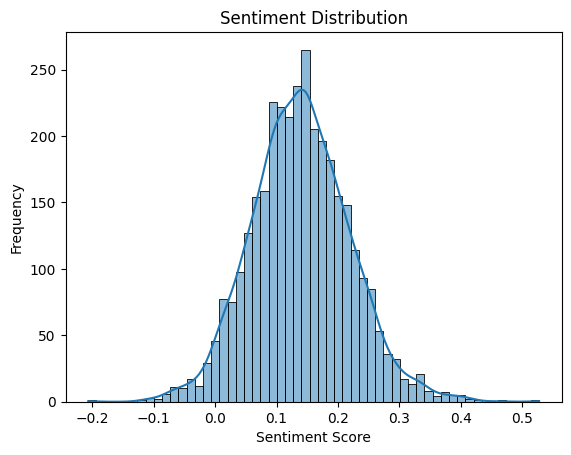

In [ ]:
sns.histplot(data['sentiment'], kde=True)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()


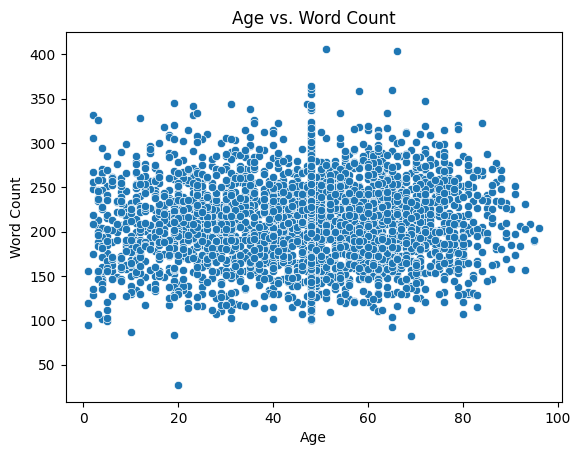

In [ ]:
sns.scatterplot(x='age', y='word_count', data=data)
plt.title('Age vs. Word Count')
plt.xlabel('Age')
plt.ylabel('Word Count')
plt.show()


In [ ]:
print(data[['cleaned_conversation']].head())

                                cleaned_conversation
0  doctor good morning feeling today patient im f...
1  doctor hello feeling today patient great ive h...
2  doctor hello feeling today patient great ive t...
3  doctor hello feeling today patient good doctor...
4  doctor good morning feeling today patient good...


In [ ]:
def assign_intent(conversation):
    # Define intents and associated keywords
    intent_keywords = {
        'symptom': ['cough', 'fever', 'breathing', 'shortness of breath'],
        'treatment': ['treatment', 'medication', 'therapy', 'physiotherapy'],
        'rehabilitation': ['rehabilitation', 'physical therapy', 'rehab']
    }

    # Convert conversation to lowercase for case-insensitive matching
    conversation = conversation.lower()

    # Check for keywords in conversation
    for intent, keywords in intent_keywords.items():
        if any(keyword in conversation for keyword in keywords):
            return intent

    return 'other'  # Default intent for unmatched cases

# Apply intent assignment function
data['intent'] = data['cleaned_conversation'].apply(assign_intent)

# Check the results
print(data[['cleaned_conversation', 'intent']].head(10))


                                cleaned_conversation   intent
0  doctor good morning feeling today patient im f...  symptom
1  doctor hello feeling today patient great ive h...  symptom
2  doctor hello feeling today patient great ive t...  symptom
3  doctor hello feeling today patient good doctor...  symptom
4  doctor good morning feeling today patient good...  symptom
5  doctor good morning feeling today patient grea...  symptom
6  doctor hello feeling today patient hmm well ex...  symptom
7  doctor hi feeling today patient good ive feeli...  symptom
8  doctor good morning feeling today patient hmm ...  symptom
9  doctor hi feeling today patient im feeling wel...  symptom


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% train, 20% test)
X = data['cleaned_conversation']
y = data['intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the size of train and test sets
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")


Training set size: 2701
Test set size: 676


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Fit the vectorizer on training data and transform both train and test data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"TF-IDF train shape: {X_train_tfidf.shape}")
print(f"TF-IDF test shape: {X_test_tfidf.shape}")


TF-IDF train shape: (2701, 5000)
TF-IDF test shape: (676, 5000)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the Logistic Regression model
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy on test set:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy on test set: 0.7470414201183432
Classification Report:
               precision    recall  f1-score   support

       other       0.75      0.40      0.52       142
     symptom       0.87      0.64      0.74       181
   treatment       0.71      0.94      0.81       353

    accuracy                           0.75       676
   macro avg       0.78      0.66      0.69       676
weighted avg       0.76      0.75      0.73       676



In [ ]:
def predict_intent(user_input):
    # Clean the user input
    cleaned_input = clean_text(user_input)

    # Convert to TF-IDF representation
    input_tfidf = vectorizer.transform([cleaned_input])

    # Predict the intent using the trained model
    intent = clf.predict(input_tfidf)[0]

    return intent

# Test the prediction function
user_input = "I am having difficulty breathing and coughing a lot."
predicted_intent = predict_intent(user_input)
print(f"Predicted intent: {predicted_intent}")

Predicted intent: symptom


In [ ]:
def generate_response(intent):
    if intent == 'symptom':
        return "It seems like you are experiencing symptoms. Please consult a healthcare professional for further evaluation."
    elif intent == 'treatment':
        return "Based on your symptoms, you may need treatment. Please consult your doctor for an appropriate treatment plan."
    elif intent == 'rehabilitation':
        return "It seems you're in need of rehabilitation. A physiotherapist can guide you through the rehabilitation process."
    else:
        return "I'm sorry, I couldn't understand your query. Please try again."

# Example response based on user input
response = generate_response(predicted_intent)
print(f"Response: {response}")


Response: It seems like you are experiencing symptoms. Please consult a healthcare professional for further evaluation.


In [ ]:
def start_conversation():
    print("Hello! I am your health assistant. How can I help you today?")

    while True:
        user_input = input("You: ")
        if user_input.lower() in ['quit', 'exit']:
            print("Goodbye! Take care.")
            break

        # Predict intent
        intent = predict_intent(user_input)

        # Generate a response based on the intent
        response = generate_response(intent)

        print(f"AI: {response}")

# Start the conversation
start_conversation()


Hello! I am your health assistant. How can I help you today?
You: hi
AI: Based on your symptoms, you may need treatment. Please consult your doctor for an appropriate treatment plan.
You: eh
AI: Based on your symptoms, you may need treatment. Please consult your doctor for an appropriate treatment plan.


KeyboardInterrupt: Interrupted by user

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

# Load your dataset
data = pd.read_excel("gpt-4.xlsx")  # Replace with your dataset
print(data.columns)  # Print column names to verify

# Ensure dataset has the required columns
if 'conversation' not in data.columns:
    raise KeyError("The dataset must have a 'conversation' column.")

# Simple intent mapping (customize as needed)
def assign_intent(conversation):
    symptom_keywords = ['cough', 'fever', 'breathing', 'shortness of breath']
    treatment_keywords = ['treatment', 'medication', 'therapy', 'physiotherapy']
    rehabilitation_keywords = ['rehabilitation', 'physical therapy', 'rehab']

    if any(keyword in conversation.lower() for keyword in symptom_keywords):
        return 'symptom'
    elif any(keyword in conversation.lower() for keyword in treatment_keywords):
        return 'treatment'
    elif any(keyword in conversation.lower() for keyword in rehabilitation_keywords):
        return 'rehabilitation'
    else:
        return 'other'

# Apply intent mapping
data['intent'] = data['conversation'].apply(assign_intent)

# Map intents to numeric labels
label_mapping = {'symptom': 0, 'treatment': 1, 'rehabilitation': 2, 'other': 3}
texts = data['conversation'].tolist()
labels = data['intent'].map(label_mapping).tolist()

# Split dataset into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Tokenizer and Model Initialization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping))

# Create a PyTorch Dataset class
class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Prepare datasets
train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
test_dataset = IntentDataset(test_texts, test_labels, tokenizer)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=lambda p: {
        "classification_report": classification_report(
            p.label_ids, p.predictions.argmax(axis=1), output_dict=True
        )
    }
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# Function for intent prediction
def predict_intent(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=128)
    outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    intents = {v: k for k, v in label_mapping.items()}  # Reverse mapping for predictions
    return intents[prediction]

# Example usage
new_input = "I have been coughing a lot and have a fever."
predicted_intent = predict_intent(new_input)
print(f"Predicted intent: {predicted_intent}")


Index(['data', 'conversation'], dtype='object')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-1-bb79fb7e8d66>:91: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wand

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Classification Report
1,0.773800,0.748851,"{'0': {'precision': 0.9790209790209791, 'recall': 0.7142857142857143, 'f1-score': 0.8259587020648967, 'support': 196.0}, '1': {'precision': 0.6360225140712945, 'recall': 0.9941348973607038, 'f1-score': 0.7757437070938215, 'support': 341.0}, '3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 139.0}, 'accuracy': 0.7085798816568047, 'macro avg': {'precision': 0.5383478310307579, 'recall': 0.5694735372154728, 'f1-score': 0.5339008030529061, 'support': 676.0}, 'weighted avg': {'precision': 0.6046919958379043, 'recall': 0.7085798816568047, 'f1-score': 0.6307936534374452, 'support': 676.0}}"


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "{'0': {'